## Naive MCMC for Estimating Parameters for a Single-Jump Diffusion Model


Assumes that:
+ volatility per asset is known
+ volatility of jump process is known
+ all random processes are Gaussian with the exception of the number of time steps for the jump (Uniform)


In [1]:
from   matplotlib   import pyplot as plt

from   scipy.linalg import block_diag
from   scipy        import stats

import numpy as np

In [2]:
# 3 assets with different drifts, volatility and number of time steps for the jump process
# # asset parameters
# drift, vol, jump time periods
mu = 0.005, 0.01, -0.001
s2 = 0.0001, 0.0002, 0.0003
nt = 5, 2, 7

# jump parameters (shared amongst all assets)
mu_j, s2_j       = 0.100, 0.0010

# solution and two text formats
solution = np.array(sum([[m, n] for m, n in zip(mu, nt)], []) + [mu_j])
string   = sum([[f' mu_{i}', f'lam_{i}'] for i in range(1, len(mu) + 1)], []) + ['mu_j']
latex    = sum([[ r'$\mu_' f'{i}$', r'$\lambda_' f'{i}$'] for i in range(1, len(mu) + 1)], []) + ['$\mu_j$']

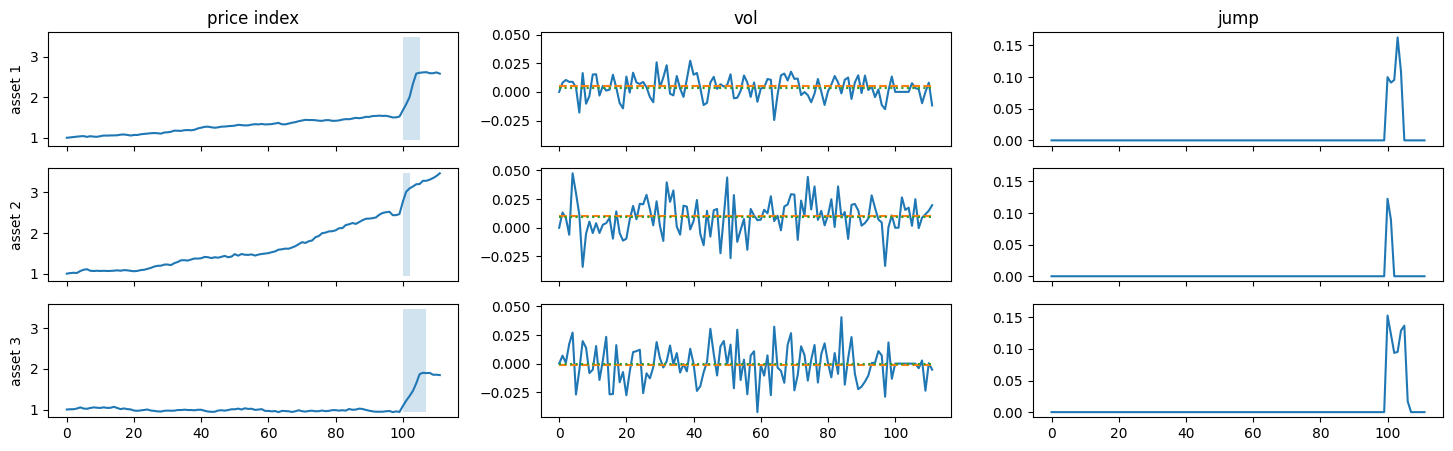

In [3]:
# assume we have access to 100 time steps before the jump process
start = 100

def generator(mu, s2, mu_j, s2_j, nt, start = start, after = 10, random_state = None):

    if random_state is not None:
        np.random.seed(random_state)

    T          = start + nt + after
    index      = np.ones(T)

    mask       = [(start <= i < start + nt) for i in range(T)]

    jump       = np.zeros_like(index, dtype = float)
    jump[mask] = np.random.normal(mu_j, np.sqrt(s2_j), size = nt)

    vol        = np.random.normal(mu  , np.sqrt(s2  ), size = T)
    vol[0]     = 0
    vol[mask]  = 0

    index     *= (1 + jump + vol)
    index      = index.cumprod()

    return index, vol, jump

index, vol, jump = [], [], []

for k, (m, s, n) in enumerate(zip(mu, s2, nt)):
    i, v, j = generator(m, s, mu_j, s2_j, n, random_state = 2022 + k)
    index.append(i)
    vol.append(v)
    jump.append(j)

min_length = min(map(len, index))
index, vol, jump = map(lambda arrays : np.array([array[:min_length] for array in arrays]), [index, vol, jump])

fig, ax = plt.subplots(len(index), 3, figsize = (18, 5), sharex = True, sharey = 'col')

for j, title in enumerate(['price index', 'vol', 'jump']):
        ax[0, j].set_title(title)

ymin, ymax = index.min(), index.max()
for i, (ind, v, j, m, n) in enumerate(zip(index, vol, jump, mu, nt)):
    ax[i, 0].plot(ind)
    ax[i, 0].fill_betweenx([ymin, ymax], start, start + n, alpha = 0.2)

    ax[i, 1].plot(v)
    ax[i, 1].plot([0, len(ind) - 1], [m] * 2, '--')
    ax[i, 1].plot([0, len(ind) - 1], [v.mean()] * 2, ':')
    ax[i, 2].plot(j)

    ax[i, 0].set_ylabel(f'asset {i + 1}')


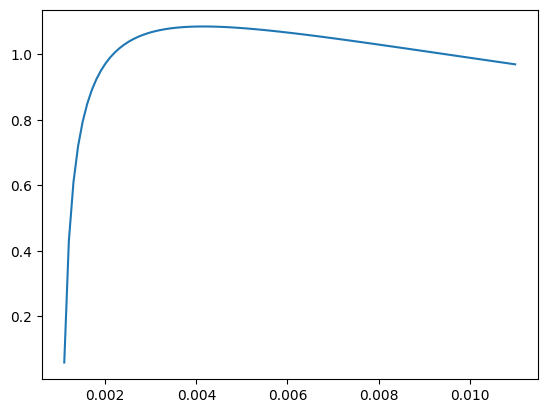

In [4]:
# Lets assume that the jump period is in the interval [1, 8]
# ideally it should be more complicated than a Uniform but I choose this for simplicity

# Lets assume the jump returns per time period is positive and has the following logpdf
x = np.linspace(0.001, 0.011, 100)

plt.plot(x, stats.lognorm(2.4, 1e-3).logpdf(x))

# i.e. we favour something around 0.004 with the right-tail characteristic

In [5]:
def log_likelihood(mu, lam, mu_j, data, start):

    nt                     = [int(l + 0.5) for l in lam]

    # percentage change
    p                      = np.insert((data[:,1:] / data[:,:-1]) - 1, 0, 0, 1)

    # masks for jump and vol period
    mask_jump                   = np.zeros_like(p, dtype = bool)
    mask_vol                    = np.zeros_like(mask_jump)

    for i, n in enumerate(nt):
        mask_jump[i,start:start + n] = True
        mask_vol[i,:start]           = True

    # log probabilities
    p_j, p_v = 0, 0
    for i, m in enumerate(mu):
        p_j += stats.norm.logpdf(p[i,mask_jump[i]], mu_j, np.sqrt(s2_j)).sum()
        p_v += stats.norm.logpdf(p[i,mask_vol [i]], m   , np.sqrt(s2[i])  ).sum()
    # p_j                    = sum(stats.norm. for i in range(len(nt)))       # same jump parameter applied to all price indexes
    # p_v                    = sum( for i, m in enumerate(mu)) # independent gaussian for each coin

    # return total log probability
    return p_j + p_v

def prior(mu, lam, mu_j, **kwargs):
    
    # lazy prior on the mean jump period to be U(1, 8)
    p_lam  = -np.inf if any((lam < 1) | (lam > 8)) else len(lam) * np.log(1 / 7)

    p_mu_j = stats.lognorm(2.4, 1e-3).logpdf(mu_j)
    return p_lam + p_mu_j

def pstar(x, data, start):
    mu, lam, mu_j = x[0:-1:2], x[1:-1:2], x[-1]
    return prior(mu, lam, mu_j) + log_likelihood(mu, lam, mu_j, data, start)

def mcmc(p, x0, n, burn = 0.2, cov = 0.01, random_state = None, **kwargs):

    if random_state is not None:
        np.random.seed(random_state)

    N   = n + int(n * burn / (1 + burn))
    c   = np.zeros(N)
    m   = len(x0)
    ret = [x0]
    old = x0
    log = np.zeros(N)
    log[0] = pstar(x0, **kwargs)
    j      = 0
    for i in range(1, N):
        new = stats.multivariate_normal(old, cov = cov).rvs()
        log[i] = pstar(new, **kwargs)
        if np.random.uniform() < np.exp(log[i] - log[j]):
            ret.append(new)
            old = new
            j   = i
        else:
            ret.append(old)
            c[i] += 1
    
    return np.array(ret[N - n:]), c, log

# mu_1, lam_1, mu_2, lam_2, ..., mu_jump
x0 = np.array([0.0, 4.5] * len(index) + [0.05])

# parameters have a negative relationship with each other hence negative covariances
# 0 for independent asset parameters

# coin covariance
# [[( mu_i, mu_i), ( mu_i, lam_i)],
#  [(lam_i, mu_i), (lam_i, lam_i)]]
block   = np.array([[ 1e-5,-1e-5],
                    [-1e-5, 1e-3]])

# two coins and mu_j covariances
cov     = block_diag(*[block] * len(index), 0)

# [(mu_1, mu_j), (lam_1, mu_j), (mu_2, mu_j), (lam_2, mu_j), (mu_j, mu_j)]
cov[-1] = cov[:,-1] = [-1e-6,-1e-5] * len(index) + [1e-5]

# scaling factor to improve acceptance rate
cov /= 5

cov
# note the block diagonal i.e. each set of asset parameters are independent

array([[ 2.e-06, -2.e-06,  0.e+00,  0.e+00,  0.e+00,  0.e+00, -2.e-07],
       [-2.e-06,  2.e-04,  0.e+00,  0.e+00,  0.e+00,  0.e+00, -2.e-06],
       [ 0.e+00,  0.e+00,  2.e-06, -2.e-06,  0.e+00,  0.e+00, -2.e-07],
       [ 0.e+00,  0.e+00, -2.e-06,  2.e-04,  0.e+00,  0.e+00, -2.e-06],
       [ 0.e+00,  0.e+00,  0.e+00,  0.e+00,  2.e-06, -2.e-06, -2.e-07],
       [ 0.e+00,  0.e+00,  0.e+00,  0.e+00, -2.e-06,  2.e-04, -2.e-06],
       [-2.e-07, -2.e-06, -2.e-07, -2.e-06, -2.e-07, -2.e-06,  2.e-06]])

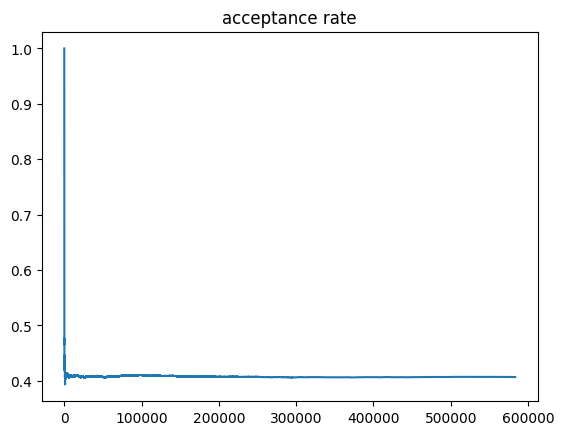

In [6]:
# execute mcmc (Metropolis) with some number of samples, n, and a burn-in period, b.
n = 500000
b = 0.2
samples, c, log = mcmc(pstar, x0, n, cov = cov, burn = b, random_state = 0, data = index, start = start)

# acceptance rate
plt.plot(1 - c.cumsum() / np.arange(1, len(c) + 1))
plt.title('acceptance rate')
plt.show()

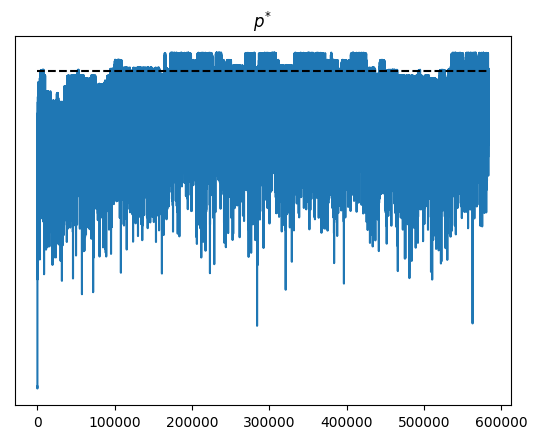

param    |  initial |    truth |  average
---------+----------+----------+---------
 mu_1    | +0.00000 | +0.00500 | +0.00426
lam_1    | +4.50000 | +5.00000 | +5.06214
 mu_2    | +0.00000 | +0.01000 | +0.00921
lam_2    | +4.50000 | +2.00000 | +2.74895
 mu_3    | +0.00000 | -0.00100 | -0.00049
lam_3    | +4.50000 | +7.00000 | +6.00171
mu_j     | +0.05000 | +0.10000 | +0.10878


In [7]:
plt.plot(log)
plt.yscale('symlog')
plt.hlines(pstar(solution, data = index, start = start), 0, len(log) - 1, ls = '--', colors = 'k')
plt.title('$p^{*}$')
plt.show()

print('param    |  initial |    truth |  average')
print('---------+----------+----------+---------')
for text, truth, x, ave in zip(string, solution, x0, samples.mean(axis = 0)):
    print(f'{text:7s}  | {x:+7.5f} | {truth:+7.5f} | {ave:+7.5f}')

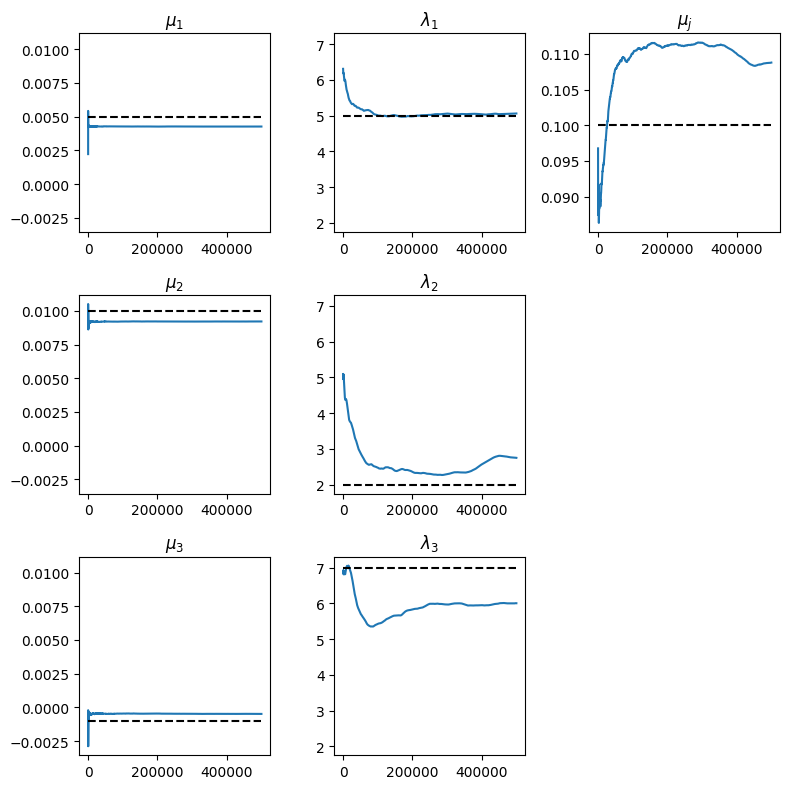

In [8]:
fig, ax = plt.subplots(len(index), 3, figsize = (8, 2 * (len(index) + 1)), sharey = 'col')

x       = np.arange(1, len(samples) + 1)

for k, (values, truth, title) in enumerate(zip(samples.T, solution, latex)):
    i, j = divmod(k, 2)
    if k == len(solution) - 1:
        i, j = 0, -1
    average = values.cumsum() / x
    ax[i, j].plot(x, average)
    ax[i, j].hlines(truth, 1, len(samples) + 1, ls = '--', colors = 'k')
    ax[i, j].set_title(title)

for i in range(1, len(index)):
    ax[i,2].set_visible(False)

plt.tight_layout()

In [10]:
average = samples.mean(axis = 0)

print('method       |    pstar |     data |    prior')
print('-------------+----------+----------+---------')
for text, values in zip(['initial', 'mcmc average', 'truth'], [x0, average, solution]):
    results = ' | '.join(f'{fun(values, data = index, start = start):8.4f}' for fun in [pstar, lambda x, **kwargs : log_likelihood(x[0:-1:2], x[1:-1:2], x[-1], **kwargs), lambda x, **kwargs : prior(x[0:-1:2], x[1:-1:2], x[-1], **kwargs)])
    print(f'{text:12s} | {results}')

# we can see that the mcmc obtains a result very close to the ground truth (and obtains a marginally better pstar value)

method       |    pstar |     data |    prior
-------------+----------+----------+---------
initial      | 834.9844 | 840.3902 |  -5.4058
mcmc average | 884.1331 | 889.9683 |  -5.8353
truth        | 882.3868 | 888.1706 |  -5.7838
